## Covariance

We’ll first look at covariance, the paired analogue of variance. Whereas
variance measures how a single variable deviates from its mean, covariance
measures how two variables vary in tandem from their means:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data = sns.load_dataset("tips")
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


<AxesSubplot:xlabel='total_bill', ylabel='tip'>

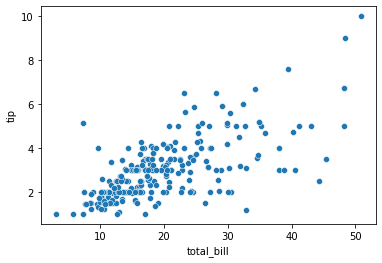

In [3]:
sns.scatterplot(x="total_bill", y="tip", data=data)

### Some utility functions

In [4]:
def de_mean(xs: list) -> list:
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    return [x - x_bar for x in xs]

In [5]:
def variance(xs: list) -> float:
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"
    n = len(xs)
    x_bar = np.mean(xs)
    squared_deviations = [(x - x_bar) ** 2 for x in xs]
    return sum(squared_deviations) / (n - 1)

In [6]:
def interquartile_range(xs: list) -> float:
    """Returns the difference between the 75%-ile and the 25%-ile"""
    return np.quantile(xs, 0.75) - np.quantile(xs, 0.25)

In [7]:
def covariance(xs: list, ys: list) -> float:
    assert len(xs) == len(ys), "xs and ys should have the same number of elements"
    return np.dot(de_mean(xs), de_mean(ys)) / (len(xs) - 1)

In [8]:
covariance([1, 2, 3], [2, 3, 4])

1.0

Nonetheless, this number can be hard to interpret, for a couple of reasons:
1. Its units are the product of the inputs’ units (e.g., friend-minutes-
per-day), which can be hard to make sense of. (What’s a “friend-
minute-per-day”?)
2. If each user had twice as many friends (but the same number of
minutes), the covariance would be twice as large. But in a sense,
the variables would be just as interrelated. Said differently, it’s hard
to say what counts as a “large” covariance.

For this reason, it’s more common to look at the correlation, which divides
out the standard deviations of both variables:

## Correlation

In [9]:
def correlation(xs: list, ys: list) -> float:
    stdev_x = np.sqrt(variance(xs))
    stdev_y = np.sqrt(variance(ys))
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs, ys) / stdev_x / stdev_y
    else:
        return 0  # if no variation, correlation is 0

The correlation is unitless and always lies between –1 (perfect
anticorrelation) and 1 (perfect correlation).

In [10]:
correlation(data["total_bill"], data["tip"])

0.6757341092113642

#### Linear Regression
In Linear Regression, we hypothesize that there are constants α (alpha) and β (beta) such that:
$$
y_{i} = \alpha + \beta * x_{i}
$$
Assuming we’ve determined such an alpha and beta , then we make predictions simply with:

In [11]:
def predict(alpha: float, beta: float, xi: float) -> float:
    return beta * xi + alpha

How do we choose alpha and beta ? Well, any choice of alpha and beta gives us a predicted output for each input xi . Since we know the actual output yi , we can compute the error for each pair:

In [12]:
def error(alpha: float, beta: float, xi: list, yi: list) -> float:
    return predict(alpha, beta, xi) - yi

In [13]:
def sum_squared_errors(alpha: float, beta: float, x: list, y: list) -> float:
    return sum(error(alpha, beta, xi, yi) ** 2 for xi, yi in zip(x, y))

The least squares solution is to choose the alpha and beta that make sum_of_sqerrors as small as possible.

In [14]:
def least_squares_fit(x: list, y: list) -> tuple:
    """
    Given two vectors x and y,
    find the least-squares values of alpha and beta
    """
    stdev_x = np.sqrt(variance(x))
    stdev_y = np.sqrt(variance(y))
    beta = correlation(x, y) * stdev_y / stdev_x
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

In [15]:
x = [i for i in range(-100, 110, 10)]
y = [3 * i - 5 for i in x]

In [16]:
least_squares_fit(x, y)

(-5.0, 3.0)

In [17]:
# Lets apply this to out dataset
least_squares_fit(data.total_bill, data.tip)

(0.9202696135546726, 0.1050245173843534)

In [18]:
max_tip = max(data.total_bill)
max_tip

50.81

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

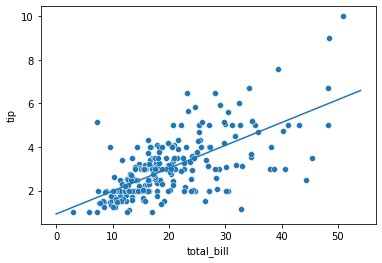

In [19]:
sns.scatterplot(x="total_bill", y="tip", data=data)
x = [*range(int(max_tip) + 5)]
alpha, beta = least_squares_fit(data.total_bill, data.tip)
y = [alpha + beta * xi for xi in x]
sns.lineplot(x=x, y=y)

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

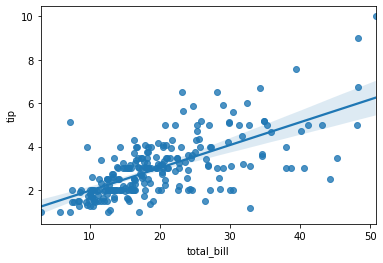

In [20]:
# Lets compare it with regression plot
sns.regplot(x="total_bill", y="tip", data=data)

We need a better way to figure out how well we’ve fit the data than staring at the graph. A common measure is the coefficient of determination (or R-squared), which measures the fraction of the total variation in the dependent variable that is captured by the model:

In [21]:
def total_sum_of_squares(y: list) -> float:
    """the total squared variation of y_i's from their mean"""
    return sum(v ** 2 for v in de_mean(y))

In [22]:
def r_squared(alpha: float, beta: float, x: list, y: list) -> float:
    """
    the fraction of variation in y captured by the model, which equals
    1 - the fraction of variation in y not captured by the model
    """
    return 1.0 - (sum_squared_errors(alpha, beta, x, y) / total_sum_of_squares(y))

In [23]:
r = r_squared(alpha, beta, data.total_bill, data.tip)
r

0.4566165863516771

Recall that we chose the alpha and beta that minimized the sum of the squared prediction errors. A linear model we could have chosen is “always predict mean(y) ” (corresponding to alpha = mean(y) and beta = 0), whose sum of squared errors exactly equals its total sum of squares. This means an R-squared of 0, which indicates a model that (obviously, in this case) performs no better than just predicting the mean. Clearly, the least squares model must be at least as good as that one, which means that the sum of the squared errors is at most the total sum of squares,
which means that the R-squared must be at least 0. And the sum of squared errors must be at least 0, which means that the R-squared can be at most 1. The higher the number, the better our model fits the data.

# Using Gradient Descent

In [24]:
! pip install tqdm

In [29]:
import tqdm
from collections import Counter, deque

In [33]:
num_epochs = 20000
np.random.seed(0)
learning_rate = 0.000005


def gradient_descent(x, y, epochs=100, learning_rate=0.01):
    guess = [0, 0] # choose random value to start
    losses = []
    with tqdm.trange(epochs) as t:
        for e in t:
            alpha, beta = guess
            # Partial derivative of loss with respect to alpha
            grad_a = sum(2 * error(alpha, beta, x_i, y_i) for x_i, y_i in zip(x, y))
            # Partial derivative of loss with respect to beta
            grad_b = sum(2 * error(alpha, beta, x_i, y_i) * x_i for x_i, y_i in zip(x, y))
            # Compute loss to stick in the tqdm description
            loss = sum_squared_errors(alpha, beta, x, y)
            
            # Early stopping
            losses.append(round(loss, 5))
            if len(losses) > 10:
                losses.clear()
            elif len(losses) == 10:
                # Check if there is any reduction in loss
                res = Counter(losses)
                if res[round(loss, 5)] == 10:
                    print("Early Stopping at", e)
                    break
            
            t.set_description(f"loss: {loss:.3f}")
            # Finally, update the guess
            guess = update(guess, [grad_a, grad_b], learning_rate)
            # print(guess)
    return guess

In [34]:
def update(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = [coeff * step_size for coeff in gradient]
    return [theta - d_theta for theta, d_theta in zip(v, step)]

In [35]:
gradient_descent(data.total_bill, data.tip, epochs=num_epochs, learning_rate=learning_rate)

loss: 252.790:  63%|██████▎   | 12516/20000 [00:24<00:14, 504.41it/s]

Early Stopping at 12516


[0.9147842075986191, 0.10525532073049292]